In [55]:
#e1 create dataset

import pandas as pd
from sklearn.datasets import fetch_openml, make_classification
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os


#concat the files into one dataset 
lidf = []
output_folder = 'Z:/Research_Projects/Reservoir_Project/data/regression_variables/varaibles_ts_clean_top_anom'
directory = output_folder +'/'

for fn in os.listdir(directory):
    rddf = pd.read_csv(directory + fn, skip_blank_lines = False, parse_dates=True, encoding='UTF-8')
    lidf.append(rddf)

seldfidk = pd.concat(lidf, axis=0, ignore_index=True)

def create_regression_dataset():
    reservoir = seldfidk
    df = reservoir[['normalized_reservoir_height', 'tws', 'precipitation', 'temp', 'volume', 'area', 'discharge', 'Res_time', 'depth', 'wshd_area','elevation' ]] #timeseries and static varaibles for algortihm to tell the difference between reservoirs 
    #df_h= df.head(3000) #change this to all data when actually running 
    
    df.to_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/reservoir_regression_data_normalized.csv')
    X = df[['tws', 'precipitation', 'temp', 'volume', 'area', 'discharge', 'Res_time', 'depth', 'wshd_area','elevation']]
    y = df['normalized_reservoir_height']
    return df, X, y


def create_datasets():
    """Create example datasets"""

    df_regression, _, __ = create_regression_dataset()
    return df_regression, 

df_regression = create_datasets()


In [62]:
#e12 rolling foward validation
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeRegressor

#add arugument that takes list in of column names and when lag features are generating, skip the static varaibles columns 

def time_series_to_tabular(included_columns):
    df, _, __ = create_regression_dataset()

    TARGET = 'normalized_reservoir_height' # The column in df we want to forecast
    LAG = 36 # This is how far back we want to look for features
    HORIZON = 6 # This is how far forward we want forecast in months

    # Fill in missing values
    cols = df.columns
    index = df.index
    df = SimpleImputer(missing_values=np.nan, strategy='mean').fit_transform(df)
    df = pd.DataFrame(df, columns=cols, index=index) # convert back to dataframe

    df = df[included_columns]    

    def create_lag_features(df, target, lag):
        """Create features for our ML model (X matrix).

        :param df: DataFrame
        :param lag: Lookback window (int)
        """
        for col in df.columns:
            for i in range(1, lag+1):
                df[f'{col}-{i}'] = df[col].shift(i)

            # Drop non-target values (we only keep historical feature values)
            if col != target:
                df = df.drop(col, axis=1)
        # OPTIONAL: Drop first N rows where N = lag
        # Alternatively, we could impute the missing data
        df = df.iloc[lag:]
        return df 

    def create_future_values(df, target, horizon):
        targets = [ target ]
        for i in range(1, horizon):
            col_name = f'{target}+{i}'
            df[col_name] = df[target].shift(-i)
            targets.append(col_name)

        # Optional: Drop rows missing future target values
        df = df[df[targets[-1]].notna()]
        return df, targets


    print('\nInitial df shape:', df.shape)
    # Create feature data (X)
    df = create_lag_features(df, TARGET, LAG)
    print('\ndf lag shape after feature creation:', df.shape)

    # Create targets to forecast (y)
    df, targets = create_future_values(df, TARGET, HORIZON)
    print('\ndf horizon shape after feature creation:', df.shape)

    # Separate features (X) and targets (y)
    y = df[targets]
    X = df.drop(targets, axis=1)
    #df.set_index('time', inplace=True)

    print('\nShape of X (features):', X.shape)
    print('Shape of y (target(s)):', y.shape)


    X.to_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/e12_X_m.csv')
    y.to_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/e12_y_m.csv')

    return X, y

In [63]:
if __name__ == '__main__':

    time_series_to_tabular(included_columns= ['normalized_reservoir_height', 'tws', 'precipitation', 'temp',])


Initial df shape: (3214, 4)

df lag shape after feature creation: (3178, 145)

df horizon shape after feature creation: (3173, 150)

Shape of X (features): (3173, 144)
Shape of y (target(s)): (3173, 6)


Combining forecast example and training regression

In [64]:
#combined block- inserting pipeline and randomized search cv in the training and evaluation of the model 
import os
import pandas as pd
import numpy as np
import math
import joblib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression, PassiveAggressiveClassifier, PassiveAggressiveRegressor, Perceptron, Ridge, SGDRegressor


# Define the regression models and their hyperparameters -- can add more! 

regression_models = {
    'RandomForestRegressor': (RandomForestRegressor,{
        'n_estimators': [20, 40, 60, 80, 90, 100 ],
        #'criterion': ['absolute_error', 'poisson', 'squared_error'],
        'max_depth': [ 20, 40, 60, 80, 100] ,
        #'max_features': ['auto', 'sqrt', 'log2'],
        #'bootstrap': [True, False]
        }        ), #will show
    #'LinearRegression': (LinearRegression, {})
} 

#add linear regress and 0 hyper params to train quickly 
#also dummyregressor train 


X, y = time_series_to_tabular(included_columns= ['normalized_reservoir_height', 'tws', 'precipitation', 'temp',])

def train_and_evaluate_model(model_name, model_constructor, param_distributions, X, y, k):
    
    print('\nTraining pipeline for', model_name, 'with k =', k)
    scaler_space = {'scaler__norm': ['l1', 'l2', 'max']}
    #feature_selector_space = {'multioutput__estimator__feature_selector__k': [1, 2, 3, 4, 5]} #change values 
    model_space = { f'multioutput__estimator__model__{key}': v for key, v in param_distributions.items()} #because it is inside the pipleine and multioutput regressor - can add as many into the dictionary as you'd like 

#'multioutput__estimator__model__n_estimators': [1,2,3]

    pipeline = Pipeline([
        ('scaler', Normalizer()),
        ('multioutput', MultiOutputRegressor(
            Pipeline([
                # ('feature_selector', SelectKBest(f_regression)),
                ('model', model_constructor())
            ])
        ))
    ])

    distributions = {
        **scaler_space,
        #**feature_selector_space,
        **model_space
    }
    
    joblib.dump(pipeline, 'Z:/Research_Projects/Reservoir_Project/ML_outputs/models/monthly_Run_test_RandomForestRegressor_35_model.joblib')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    #call select kbest
    selector = SelectKBest(k=k)
    #print (y_train, y_train.shape, type(y_train))
    #print(X_test,X_test.shape, type (X_test) )

    #add static varaibles back into the dataframe to pass
    #dont pass static through lag or select Kbest !!!
    #X_train [name of column]......

    X_train = selector.fit_transform(X_train, y_train['normalized_reservoir_height']) #fit vs. fittransform vs. transform
    X_test = selector.transform(X_test)
    # ['normalized_reservoir_height']
    #print(X_train.shape)

    clf = RandomizedSearchCV(pipeline, param_distributions=distributions, n_iter=2, verbose=1, cv= 2, scoring = 'neg_mean_absolute_error') #change n_iter -- cv = 5 without specification, more things in here to play around with  
    # print (y_train, y_train.shape, type(y_train))
    # print(X_train,X_train.shape, type (X_train) )
    clf.fit(X_train, y_train)

    # Save the trained model
    model_filename = f'Z:/Research_Projects/Reservoir_Project/ML_outputs/models/Run_test_{model_name}_{k}_model.joblib'
    joblib.dump(clf.best_estimator_, model_filename)
    print(f'Trained model saved to: {model_filename}')


    # Export RandomizedSearchCV parameters as CSV
    cv_results_df = pd.DataFrame(clf.cv_results_)
    cv_results_df.drop(columns='params', inplace=True)
    cv_results_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/month_Run_{model_name}_{k}_randomized_search_results.csv', index=False) #to know model and k value for each csv 
    #print('Randomized search results saved to randomized_search_results.csv')

    # Evaluate the model
    predictions = clf.predict(X_test)

    # Save predicted and actual values to CSV
    predictions_df = pd.DataFrame(predictions, columns=[f'Predicted_{col}' for col in y_test.columns])
    actual_df = y_test.reset_index(drop=True)  # Reset index for correct alignment
    result_df = pd.concat([actual_df, predictions_df], axis=1)
    result_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/predicted_vs_actual/month_Run_{model_name}_{k}_predicted_vs_actual.csv', index=False)
    
    mse = mean_squared_error(y_test, predictions, multioutput = 'raw_values')
    mae = mean_absolute_error(y_test, predictions, multioutput = 'raw_values')
    mape = mean_absolute_percentage_error(y_test, predictions, multioutput = 'raw_values')
    #print(mse.shape)
    #print('Mean Squared Error for', model_name, ':', mse)

#testing to add error values per day to a csv so they can all be plot together for different k values 

    #Save error values to CSV
    error_df = pd.DataFrame({'Model Name_month': [model_name], 'k': [k]})
    error_df['k'] = k  # Add 'k' as a separate column


    for horizon in range(1, len(mse) + 1):
        error_df[f'{horizon} MAE'] = mae[horizon - 1]
        error_df[f'{horizon} MSE'] = mse[horizon - 1]
        error_df[f'{horizon} MAPE'] = mape[horizon - 1]

    error_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/error_results_per_FH/month_Run_results_{model_name}_{k}.csv', index=False)


    # # # Plot the box plot to visualize the effect of k on model performance for MSE 
    forecast_horizons = np.arange(1, len(mse) + 1)

    plt.figure(figsize=(10, 6))
    plt.bar(forecast_horizons, mae, color='skyblue')
    plt.xlabel('Forecast Horizon')
    plt.ylabel('Mean Absolute Error')
    plt.title(f'Effect of Feature Selector (k) on Model Performance for {model_name} (k = {k})')
    plt.xticks(forecast_horizons)
    plt.savefig('Z:/Research_Projects/Reservoir_Project/ML_outputs/RF_model_output_error/month_Run_'+model_name+'_'+str(k)+'_mae')


    # plt.figure(figsize=(10, 6))
    # plt.bar(forecast_horizons, mae, color='skyblue')
    # plt.xlabel('Forecast Horizon')
    # plt.ylabel('Mean Absolute Error')
    # plt.title(f'Effect of Feature Selector (k) on Model Performance for {model_name} (k = {k})')
    # plt.xticks(forecast_horizons)
    # #plt.savefig('Z:/Research_Projects/Reservoir_Project/ML_outputs/RF_model_output_error/Run35_'+model_name+'_'+str(k)+'mae')


    # plt.figure(figsize=(10, 6))
    # plt.bar(forecast_horizons, mape, color='skyblue')
    # plt.xlabel('Forecast Horizon')
    # plt.ylabel('Mean Absolute Percentage Error')
    # plt.title(f'Effect of Feature Selector (k) on Model Performance for {model_name} (k = {k})')
    # plt.xticks(forecast_horizons)
    # #plt.savefig('Z:/Research_Projects/Reservoir_Project/ML_outputs/RF_model_output_error/Run35'+model_name+'_'+str(k)+'mape')

    return cv_results_df, predictions, y_test


all_predictions= {}

def regression_scores_up(y_test, predictions):
    results = {
        'MAE': mean_absolute_error(y_test, predictions),
        'MAE2': median_absolute_error(y_test, predictions),
        'MAPE': mean_absolute_percentage_error(y_test, predictions),
        'ME': np.mean(y_test - predictions),
        'MSE': mean_squared_error(y_test, predictions),
        'R2': r2_score(y_test, predictions),
        'RMSE': math.sqrt(mean_squared_error(y_test, predictions)),
    }
    return results

#actual_values = pd.DataFrame()  
model_results = []
error_results = []

def regression_and_error_score(y_test, predictions, model_name, k):

    for model_name, (model_class, param_grid) in regression_models.items():
        scores = regression_scores_up(y_test, predictions)
        scores['Model'] = model_name
        model_results.append(scores)

        # for horizon_period in range(0, 10): # by period
        for day in range(0, len(y_test)): # by day
            # Select the values for the specific day
            actual = y_test.iloc[day, :]  # Use y_test as the actual values for each day
            predicted = predictions[day, :]  # Reshape predicted values to match the shape of actual values
            scores_by_day = regression_scores_up(actual, predicted) 
            scores_by_day['day']= day
            error_results.append(scores_by_day)

    # Convert results and error values to DataFrames
    results_df = pd.DataFrame(model_results)
    errors_df = pd.DataFrame(error_results)

    # Save results and error values to CSV
    results_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/regression_results/month_Run_regression_results_for_{model_name}_k={k}.csv', index=False)
    errors_df.to_csv(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/regression_results/month_Run_error_resultsfor_{model_name}_k={k}.csv', index=False)
    return(results_df, errors_df)



Initial df shape: (3214, 4)

df lag shape after feature creation: (3178, 145)

df horizon shape after feature creation: (3173, 150)

Shape of X (features): (3173, 144)
Shape of y (target(s)): (3173, 6)



Training pipeline for RandomForestRegressor with k = 1

Training pipeline for RandomForestRegressor with k = 1
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Trained model saved to: Z:/Research_Projects/Reservoir_Project/ML_outputs/models/Run_test_RandomForestRegressor_1_model.joblib

Saved errors for RandomForestRegressor with k = 1

Training pipeline for RandomForestRegressor with k = 5

Training pipeline for RandomForestRegressor with k = 5
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Trained model saved to: Z:/Research_Projects/Reservoir_Project/ML_outputs/models/Run_test_RandomForestRegressor_5_model.joblib

Saved errors for RandomForestRegressor with k = 5

Training pipeline for RandomForestRegressor with k = 10

Training pipeline for RandomForestRegressor with k = 10
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Trained model saved to: Z:/Research_Projects/Reservoir_Project/ML_outputs/models/Run_test_RandomForestRegressor_10_model.joblib



c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



Saved errors for RandomForestRegressor with k = 100

Training pipeline for RandomForestRegressor with k = 105

Training pipeline for RandomForestRegressor with k = 105
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Trained model saved to: Z:/Research_Projects/Reservoir_Project/ML_outputs/models/Run_test_RandomForestRegressor_105_model.joblib

Saved errors for RandomForestRegressor with k = 105

Training pipeline for RandomForestRegressor with k = 110

Training pipeline for RandomForestRegressor with k = 110
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Trained model saved to: Z:/Research_Projects/Reservoir_Project/ML_outputs/models/Run_test_RandomForestRegressor_110_model.joblib

Saved errors for RandomForestRegressor with k = 110

Training pipeline for RandomForestRegressor with k = 115

Training pipeline for RandomForestRegressor with k = 115
Fitting 2 folds for each of 2 candidates, totalling 4 fits
Trained model saved to: Z:/Research_Projects/Reservoir_Pro

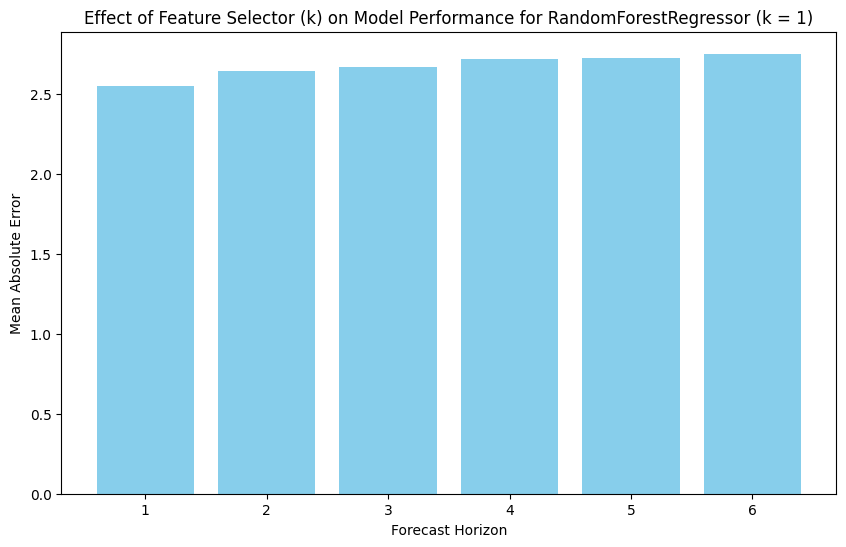

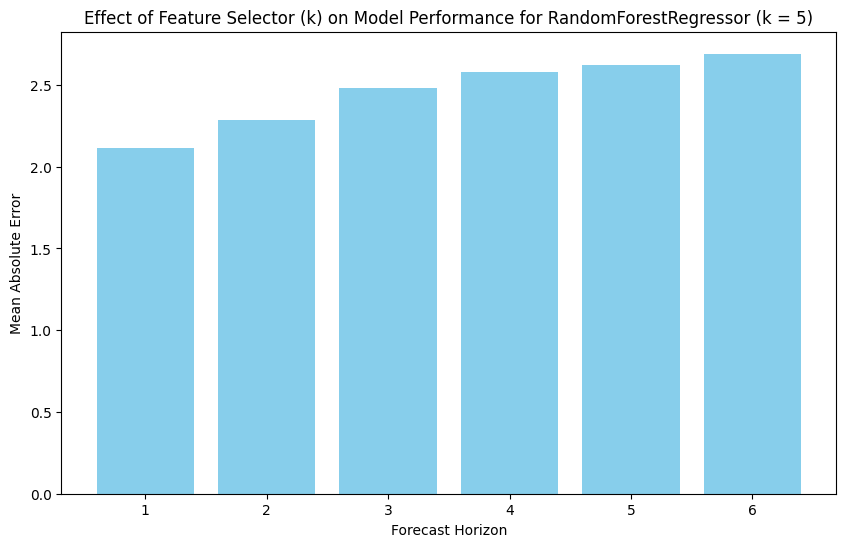

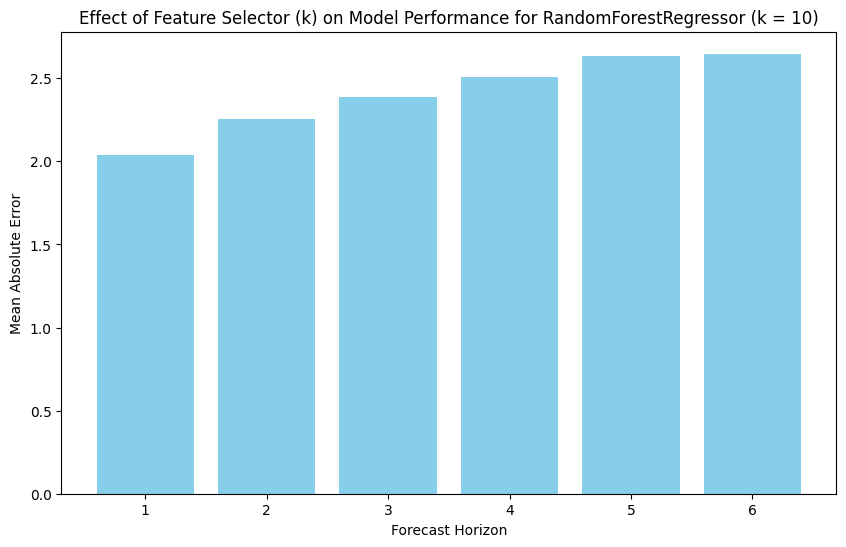

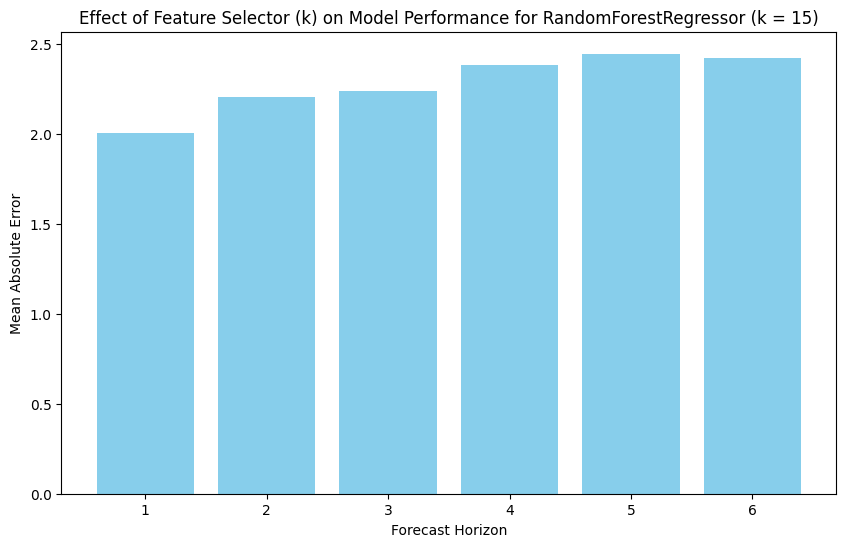

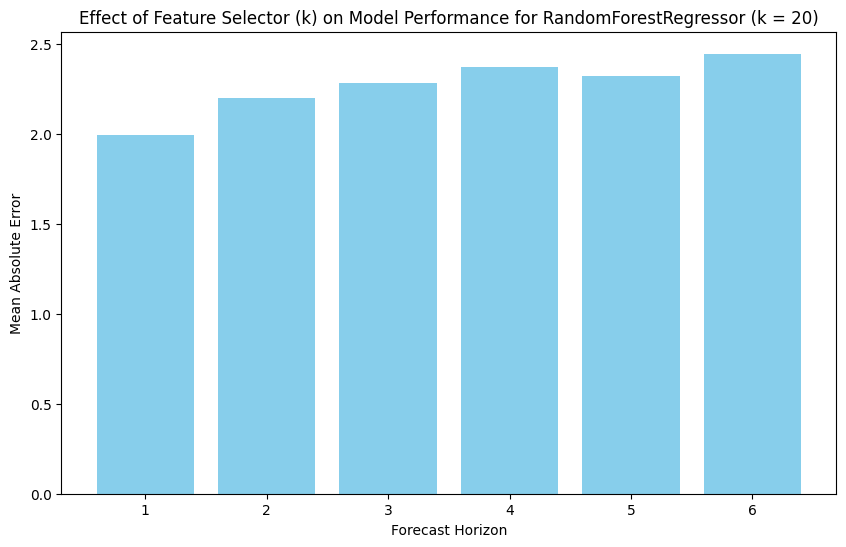

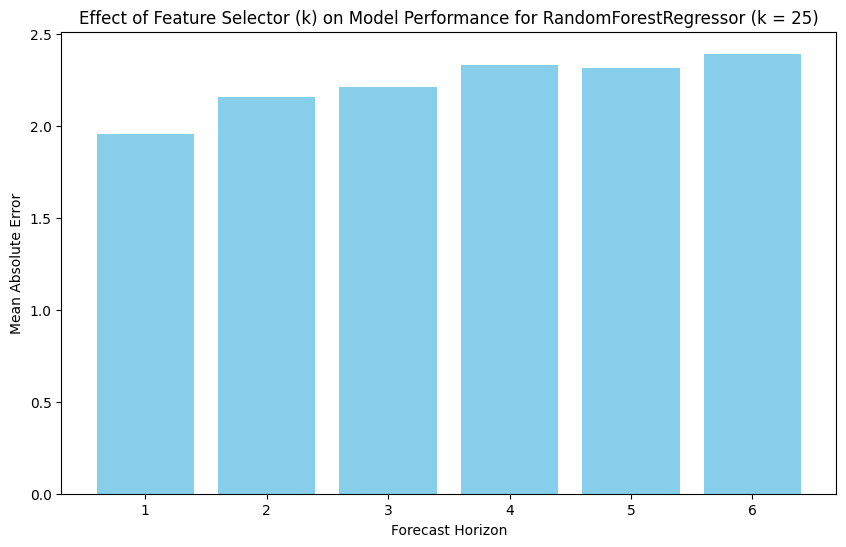

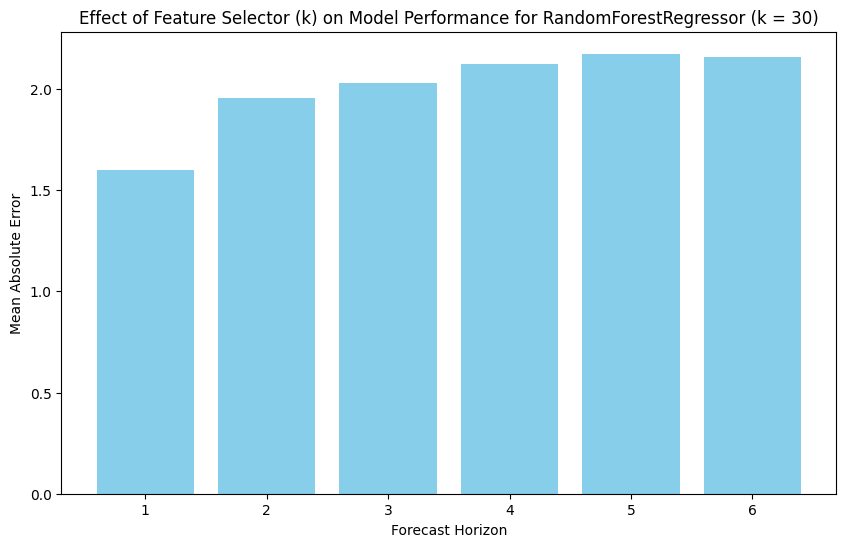

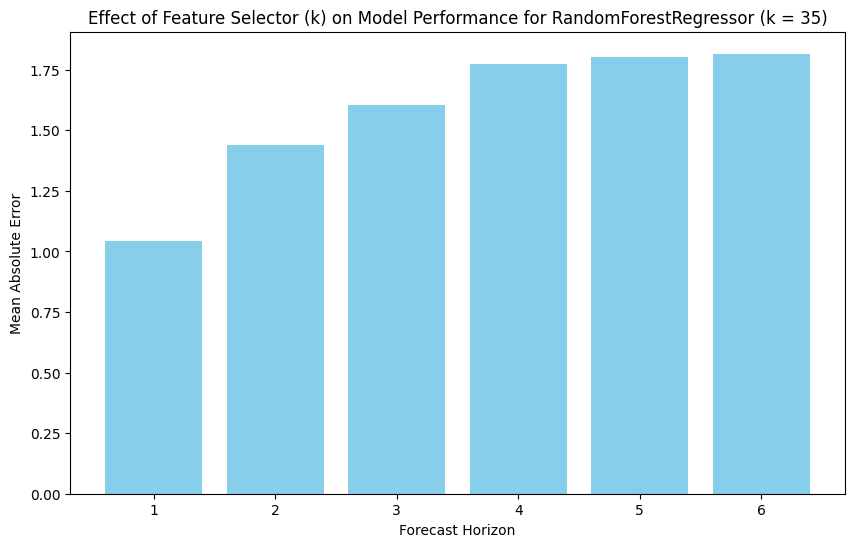

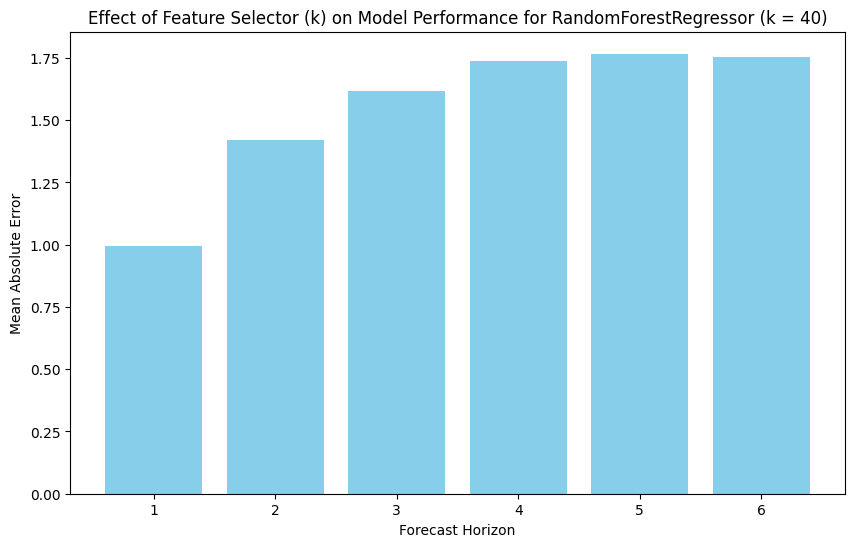

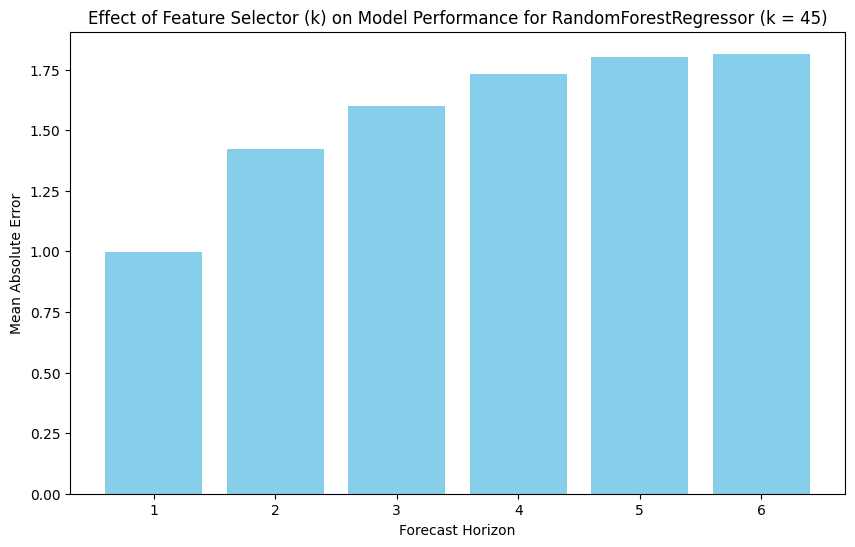

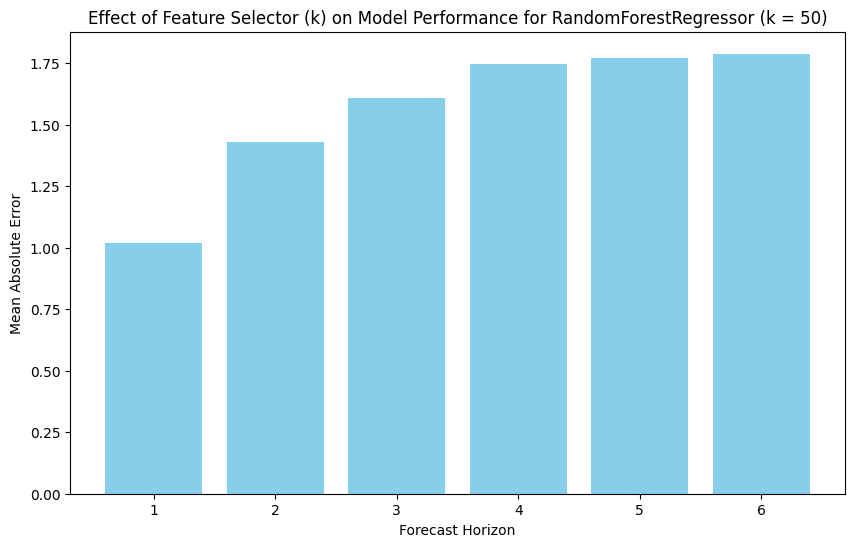

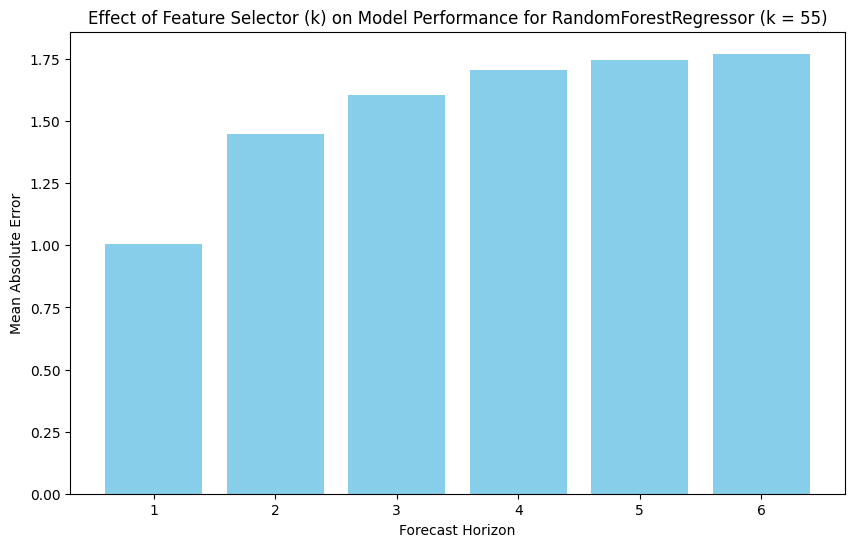

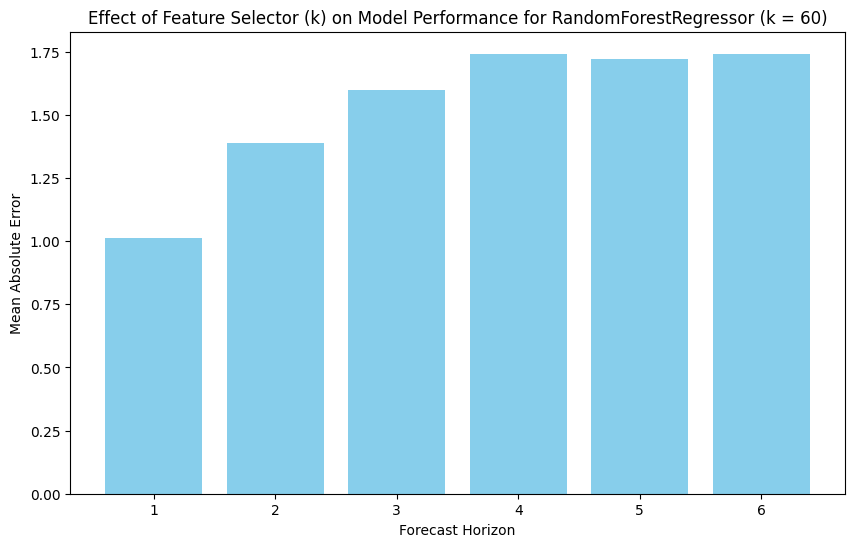

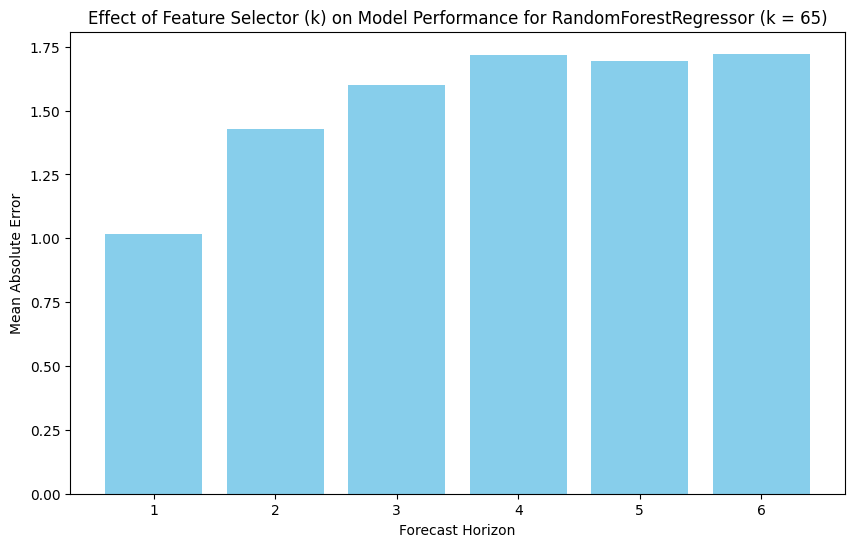

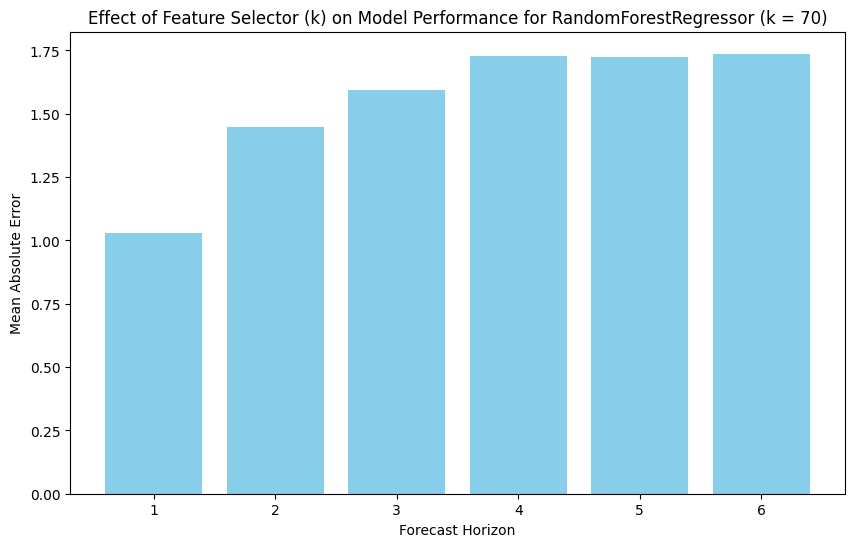

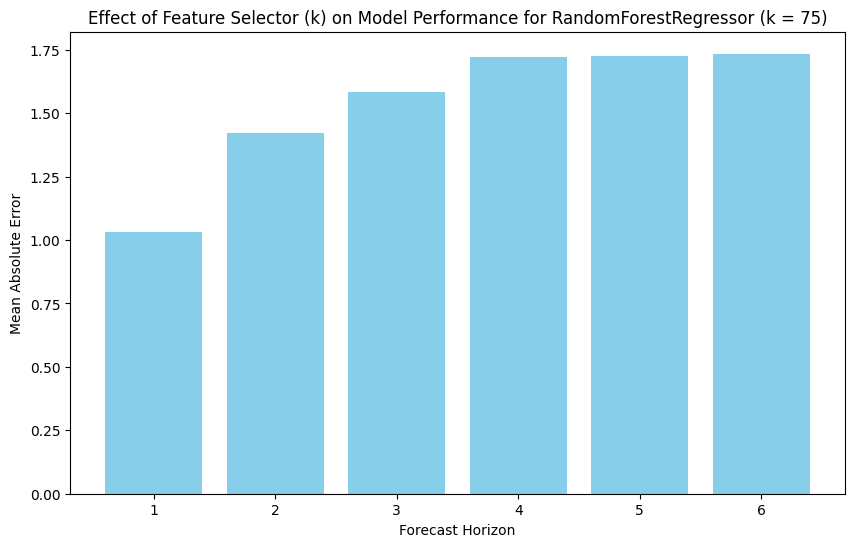

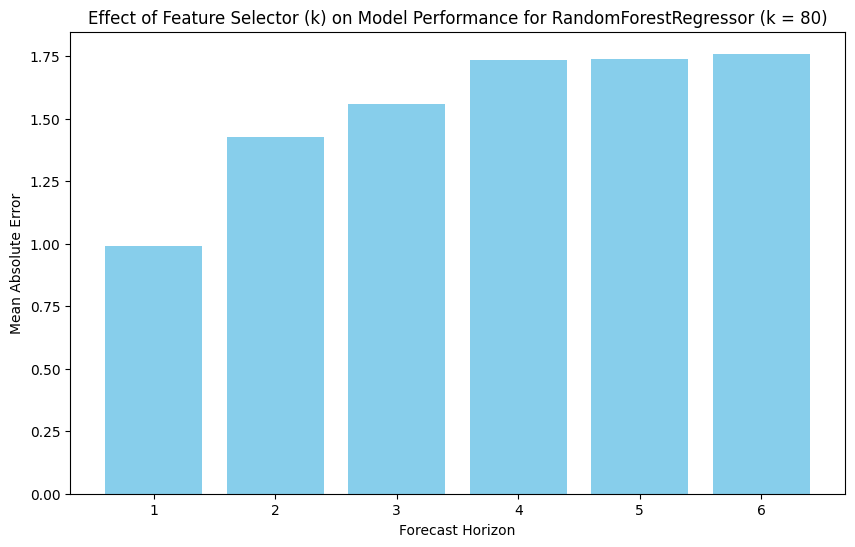

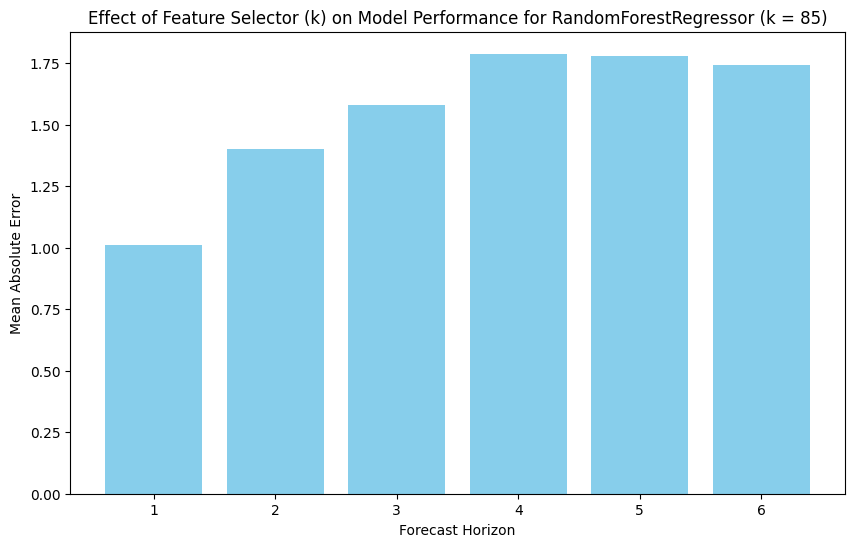

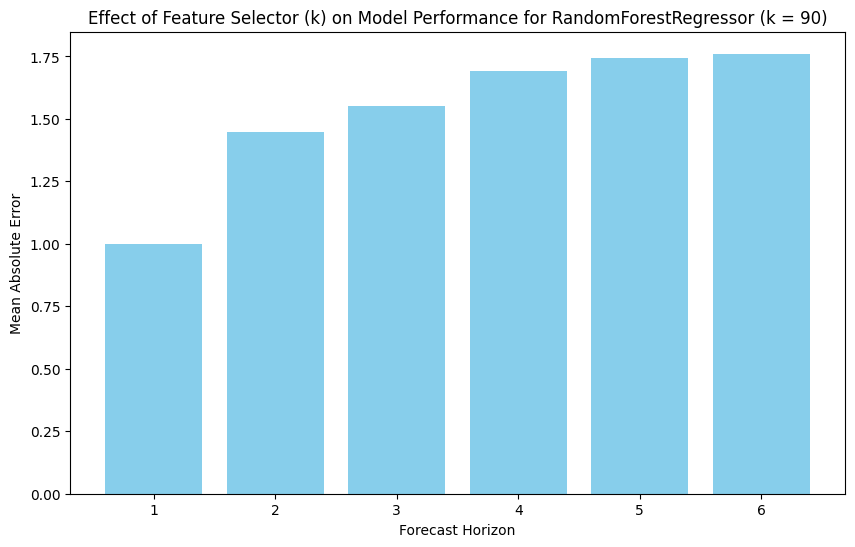

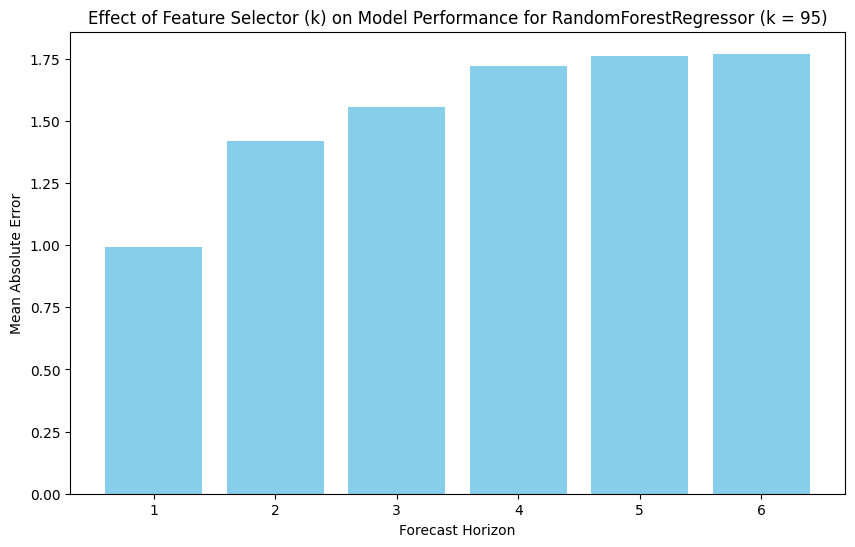

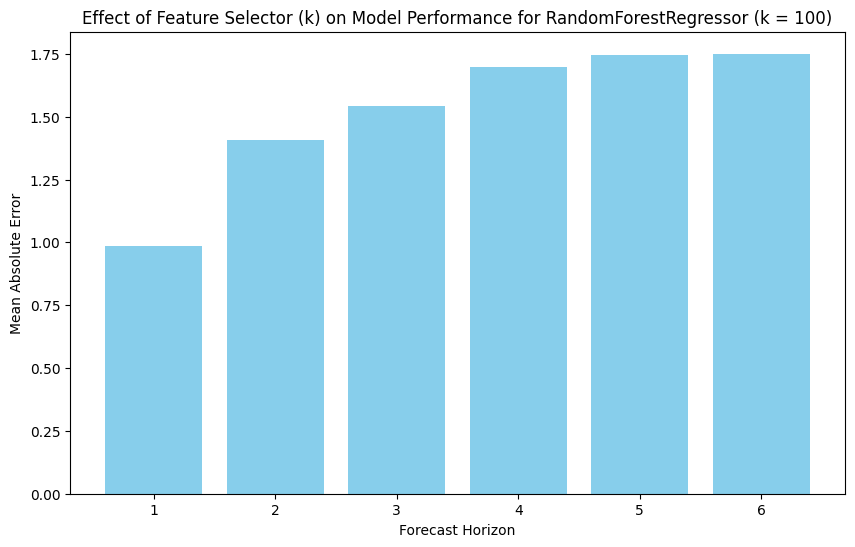

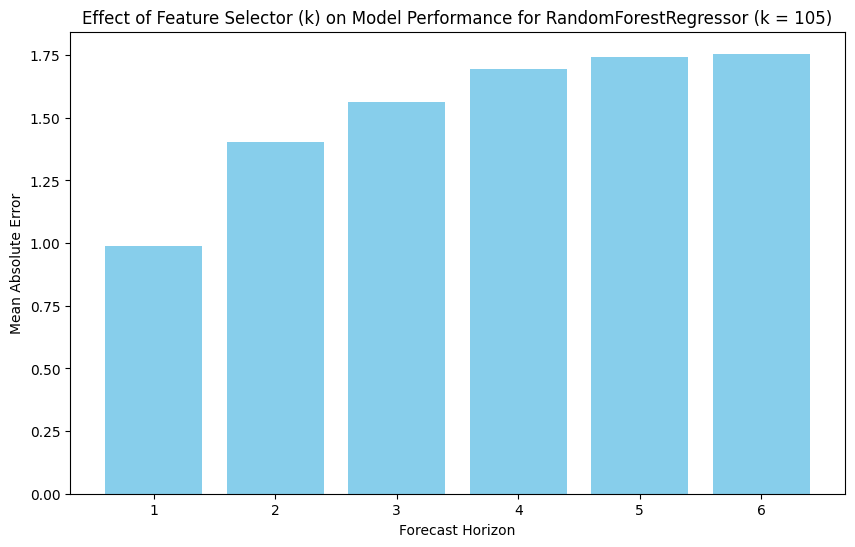

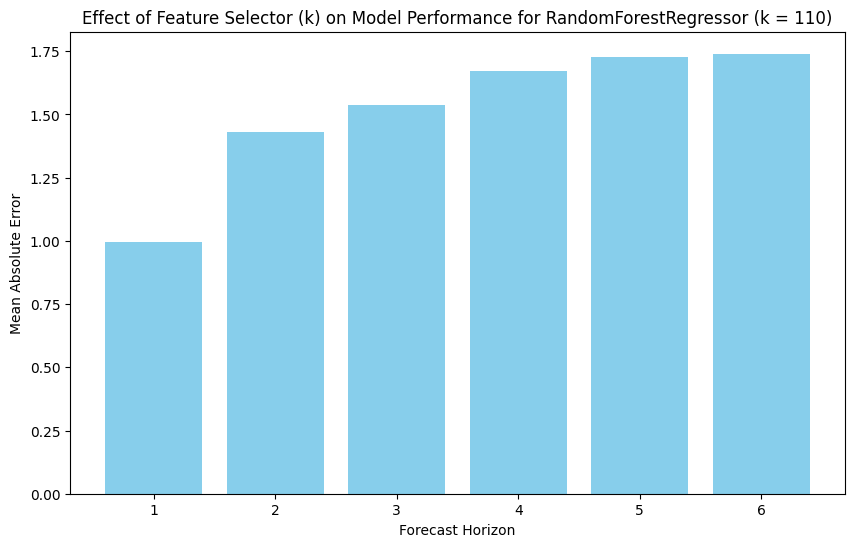

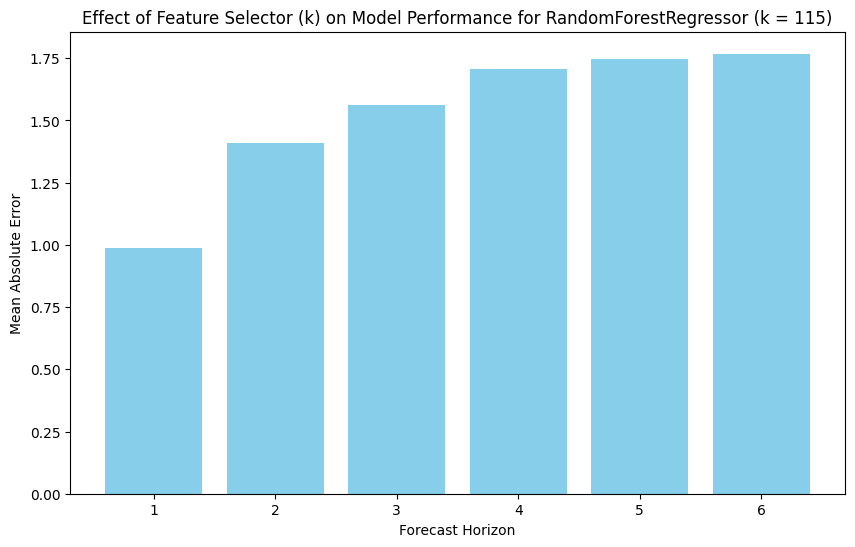

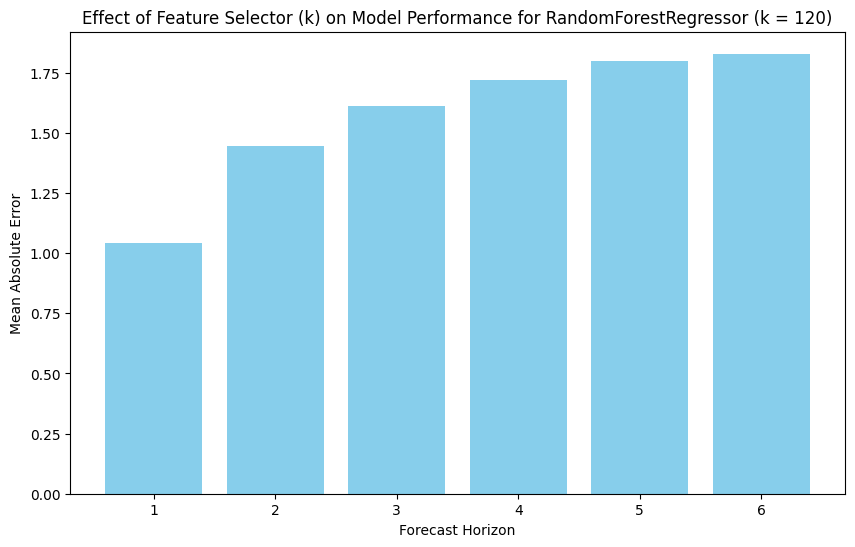

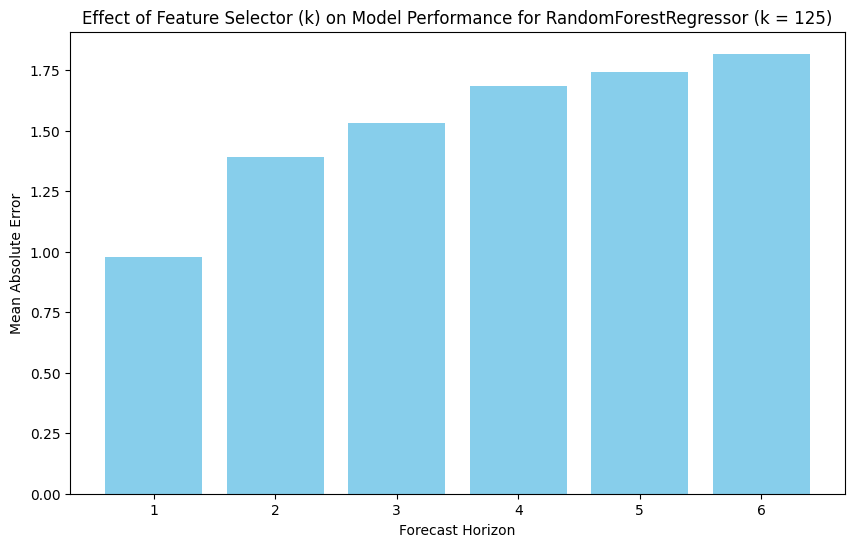

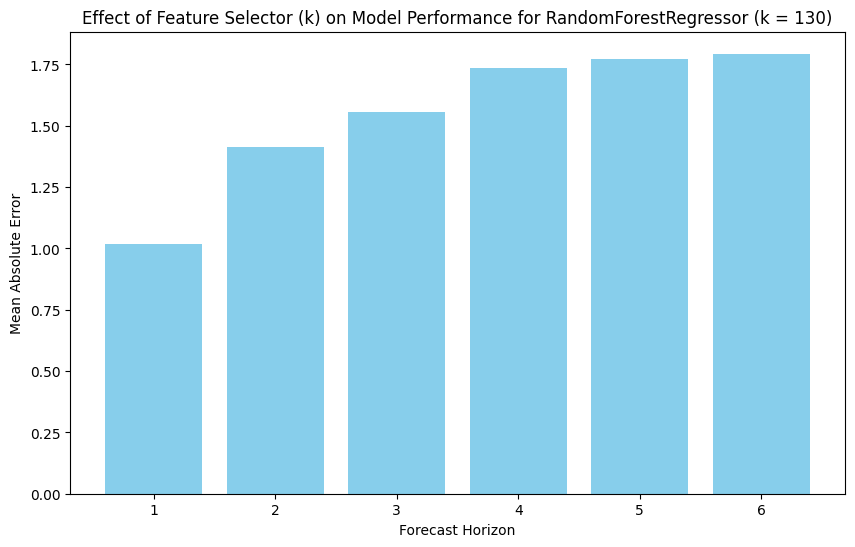

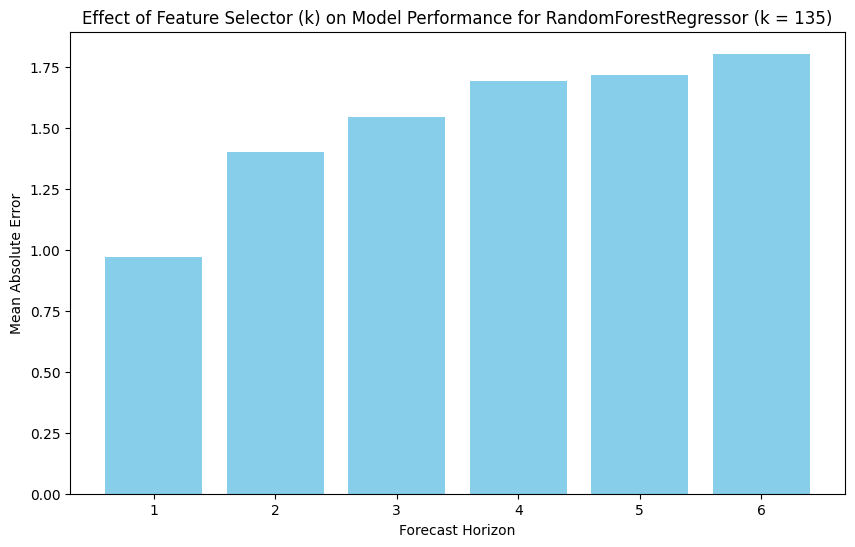

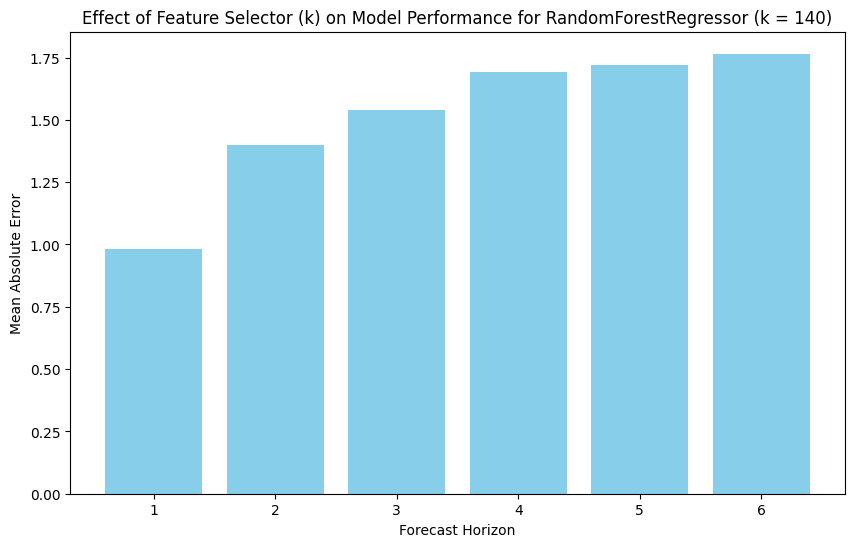

In [67]:

#run the above cells
#model_mean_test_scores = {}
for model_name, (model_constructor, hyperparameters) in regression_models.items():
    k_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140]
    for k in k_values:
        print('\nTraining pipeline for', model_name, 'with k =', k)
        # mean_test_scores, 
        cv_results_df, predictions, y_test = train_and_evaluate_model(model_name, model_constructor, hyperparameters, X, y, k)
        results = regression_scores_up(y_test, predictions)
        results_df, errors_df = regression_and_error_score(y_test, predictions, model_name, k)
        print('\nSaved errors for', model_name, 'with k =', k)
        
        #model_mean_test_scores[model_name] = mean_test_scores
        all_predictions[model_name] = predictions

In [49]:
import joblib
import pandas as pd

# Load the trained pipeline
loaded_pipeline = joblib.load('Z:/Research_Projects/Reservoir_Project/ML_outputs/models/Run_test_RandomForestRegressor_35_model.joblib')

# Prepare new data
res_name = 'agua_vermelha'
input_data_path = 'Z:/Research_Projects/Reservoir_Project/data/regression_variables/varaibles_ts_clean_top_anom/' + res_name + '_var_normalized.csv'

# Load input data
input_data = pd.read_csv(input_data_path)
input_data = input_data.dropna()


# Extract features and target
X_new = input_data[['tws', 'precipitation', 'temp', 'volume', 'area', 'discharge', 'Res_time', 'depth', 'wshd_area', 'elevation']]
y_new = input_data['normalized_reservoir_height']



#through pipeline
scaler = loaded_pipeline.named_steps['scaler']
X_new_normalized = scaler.transform(X_new)
predictions_new = loaded_pipeline.predict(X_new_normalized)

predictions_new = loaded_pipeline.predict(X_new)

#another option
# print(loaded_pipeline.named_steps)
# multioutput_regressor = loaded_pipeline.named_steps['multioutput']
# model_regressor = multioutput_regressor.estimators_[0]  
# X_new_transformed = X_new

# predictions_new = model_regressor.predict(X_new_transformed)



c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but Normalizer was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


ValueError: X has 10 features, but Normalizer is expecting 35 features as input.

0.0016484552422331156
16.972558853477956
2.952946514060497


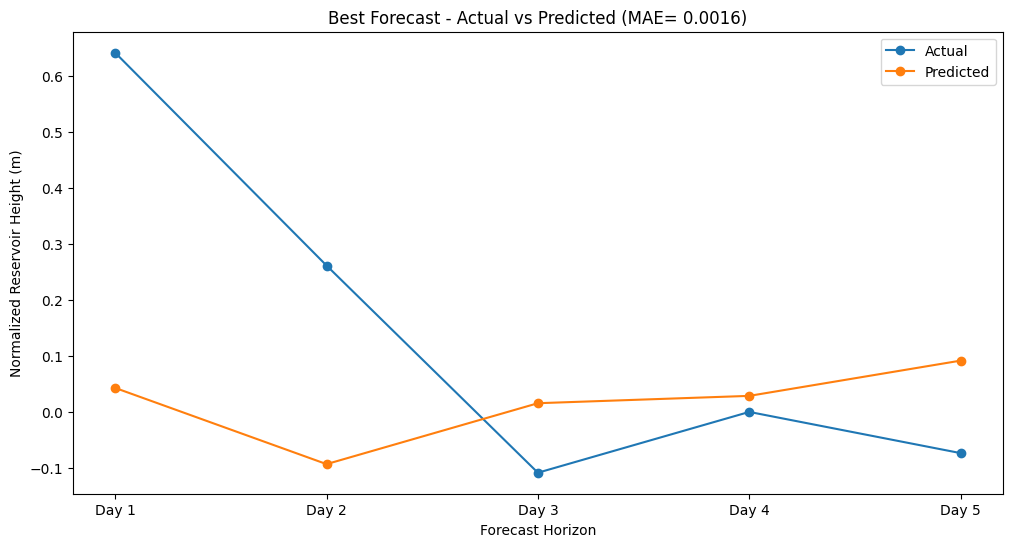

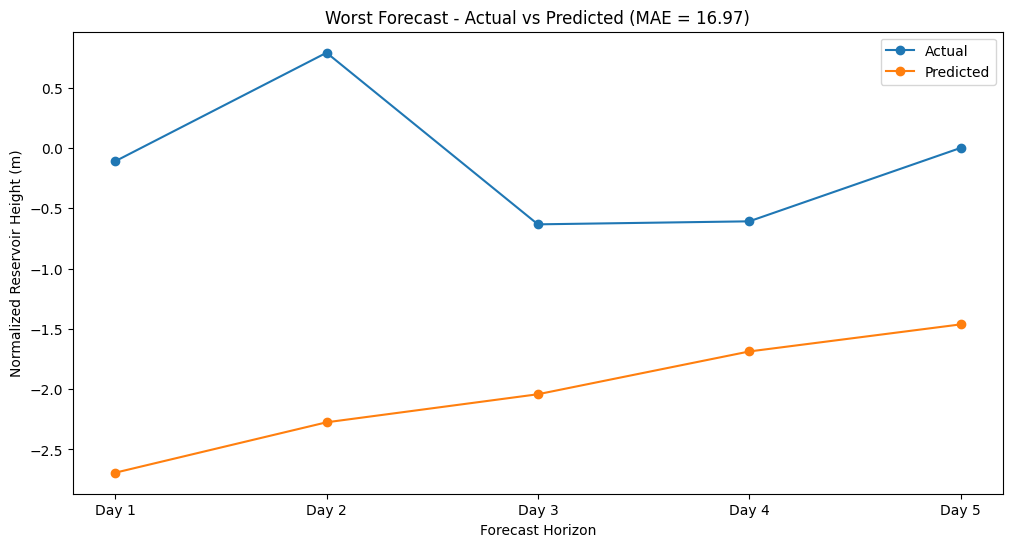

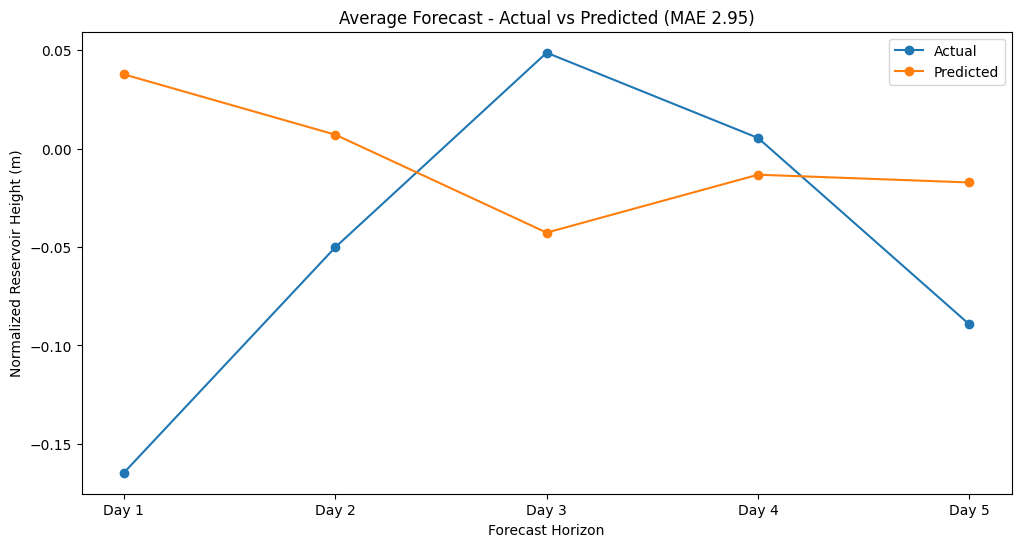

In [35]:
#plotting actual vs. predicted

# Plotting Best, Worst, and Average Days
predicted_actual_df = pd.read_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/predicted_vs_actual/Run35_RandomForestRegressor_1_predicted_vs_actual.csv')
# Calculate metrics for each day

predicted_cols = [f'Predicted_normalized_reservoir_height+{i}' for i in range(1, 4+ 1)]
actual_cols = [f'normalized_reservoir_height+{i}' for i in range(1, 4 + 1)]

mean_mae_store = []

for index, row in predicted_actual_df.iterrows():
    for p, a in zip(predicted_cols, actual_cols):
        #print(row[p])
        #print(row[a])
        mae = mean_absolute_error([row[p]], [row[a]]) #needs to be a list
        #print(mae)
        mean_mae= np.mean(mae)
        mean_mae_store.append(mean_mae)

predicted_actual_df['MAE'] = pd.Series(mean_mae_store)

# Find best, worst, and average days
best_day = predicted_actual_df.loc[predicted_actual_df['MAE'].idxmin()]
worst_day = predicted_actual_df.loc[predicted_actual_df['MAE'].idxmax()]
average_day = predicted_actual_df.mean()

print(best_day['MAE'])
print(worst_day['MAE'])
print(average_day['MAE'])

best_day = best_day.drop('MAE')
worst_day =worst_day.drop('MAE')
average_day =average_day.drop('MAE')


# Plotting the best, worst, and average days
plt.figure(figsize=(12, 6))
plt.plot(best_day.index[len(predicted_actual_df.columns)//2:], best_day.values[:len(predicted_actual_df.columns)//2], label='Actual', marker='o')
plt.plot(best_day.index[len(predicted_actual_df.columns)//2:], best_day.values[len(predicted_actual_df.columns)//2:], label='Predicted', marker='o')
custom_labels = ['Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5']
plt.xticks(best_day.index[len(predicted_actual_df.columns)//2:], custom_labels)
plt.title('Best Forecast - Actual vs Predicted (MAE= 0.0016)')
plt.xlabel('Forecast Horizon') #pass in a list of names 
#plt.xticks(["Day 1", "Day 2", "Day 3", "Day 4", "Day 5"])
plt.ylabel('Normalized Reservoir Height (m)')
plt.legend()
plt.savefig('Z:\Research_Projects\Reservoir_Project\ML_outputs/best_forecast_rf35_csv')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(worst_day.index[len(predicted_actual_df.columns)//2:], worst_day.values[:len(predicted_actual_df.columns)//2], label='Actual', marker='o')
plt.plot(worst_day.index[len(predicted_actual_df.columns)//2:], worst_day.values[len(predicted_actual_df.columns)//2:], label='Predicted', marker='o')
plt.xticks(worst_day.index[len(predicted_actual_df.columns)//2:], custom_labels)
plt.title('Worst Forecast - Actual vs Predicted (MAE = 16.97)')
plt.xlabel('Forecast Horizon')
plt.ylabel('Normalized Reservoir Height (m)')
plt.legend()
plt.savefig('Z:\Research_Projects\Reservoir_Project\ML_outputs/worst_forecast_rf35_csv')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(average_day.index[len(predicted_actual_df.columns)//2:], average_day.values[:len(predicted_actual_df.columns)//2], label='Actual', marker='o')
plt.plot(average_day.index[len(predicted_actual_df.columns)//2:], average_day.values[len(predicted_actual_df.columns)//2:], label='Predicted', marker='o')
plt.xticks(average_day.index[len(predicted_actual_df.columns)//2:], custom_labels)
plt.title('Average Forecast - Actual vs Predicted (MAE 2.95)')
plt.xlabel('Forecast Horizon')
plt.ylabel('Normalized Reservoir Height (m)')
plt.legend()
plt.savefig('Z:\Research_Projects\Reservoir_Project\ML_outputs/avg_forecast_rf35_csv')
plt.show()

c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


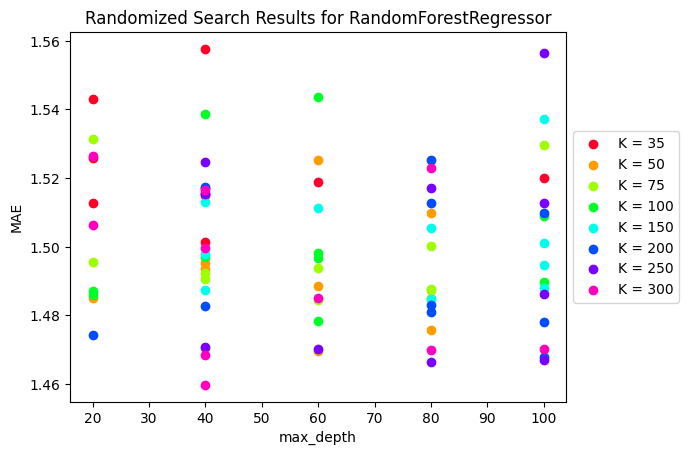

c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


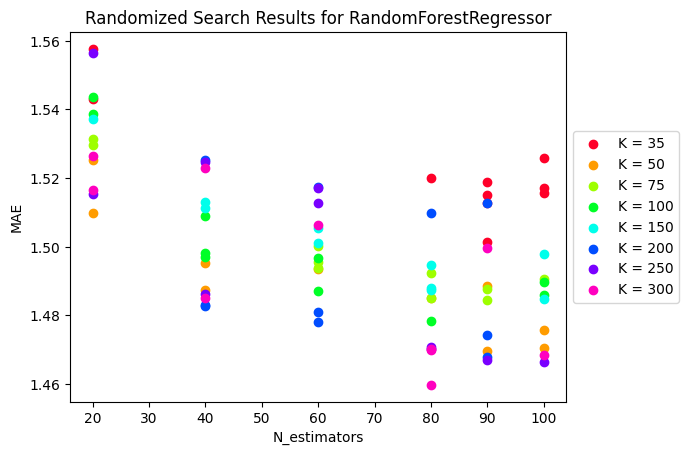

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import numpy as np

# Assuming all_predictions, model_name, and k_values are defined

for model_name, predictions in all_predictions.items():
    all_dataframes = []

    for k in k_values:
        results_indv = pd.read_csv('Z:/Research_Projects/Reservoir_Project/ML_outputs/tables_outputs_csv/Run2F_'+ model_name + '_'+ str(k) +'_randomized_search_results.csv')
        results_indv['k'] = k  # Add a 'k' column to the DataFrame
        all_dataframes.append(results_indv)

    # Concatenate the dataframes along the rows
    results = pd.concat(all_dataframes, ignore_index=True)

    param_hyperparam1 = 'param_multioutput__estimator__model__max_depth'
    param_hyperparam2 = 'param_multioutput__estimator__model__n_estimators'
    param_hyperparam3 = 'param_scaler__norm'

    k_values_unique = sorted(set(k_values))
    cmap = get_cmap('gist_rainbow', len(k_values_unique))  # Use a suitable color map

    for i, k in enumerate(k_values_unique):
        # Filter the results for the current K value
        filtered_results = results[results['k'] == k]

        # Take the absolute value of mean_test_score
        filtered_results['mean_test_score'] = np.abs(filtered_results['mean_test_score'])

        # Plot the scatter plot with a unique color for each K value
        plt.scatter(filtered_results[param_hyperparam1], filtered_results['mean_test_score'], label=f'K = {k}', color=cmap(i))

    plt.xlabel('max_depth')
    plt.ylabel('MAE')
    plt.title('Randomized Search Results for ' + model_name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    #plt.savefig(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/Hyperparameters/HP_max_depth_{model_name}.png')

    for i, k in enumerate(k_values_unique):
        # Filter the results for the current K value
        filtered_results = results[results['k'] == k]

        # Take the absolute value of mean_test_score
        filtered_results['mean_test_score'] = np.abs(filtered_results['mean_test_score'])
        
        # Plot the scatter plot with a unique color for each K value
        plt.scatter(filtered_results[param_hyperparam2], filtered_results['mean_test_score'], label=f'K = {k}', color=cmap(i))

    plt.xlabel('N_estimators')
    plt.ylabel('MAE')
    plt.title('Randomized Search Results for ' + model_name)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    #plt.savefig(f'Z:/Research_Projects/Reservoir_Project/ML_outputs/Hyperparameters/HP_n_estimator_{model_name}.png')



Fitting 2 folds for each of 4 candidates, totalling 8 fits
Randomized search results saved to randomized_search_results.csv
(5,)
Mean Squared Error for RandomForestRegressor : [13.37292113 16.53387753 18.05875245 21.73705031 18.53310134]


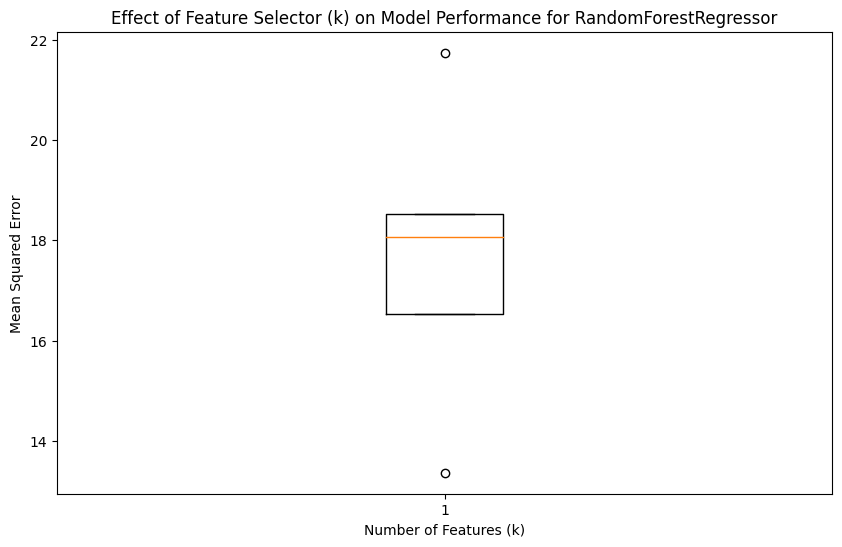

ValueError: not enough values to unpack (expected 5, got 2)

In [102]:
#score? 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import math
from scipy.stats import pearsonr

def regression_scores_up(actual, predicted):
    results = {
        'MAE': mean_absolute_error(actual, predicted),
        'MAE2': median_absolute_error(actual, predicted),
        'MAPE': mean_absolute_percentage_error(actual, predicted),
        'ME': np.mean(actual - predicted),
        'MSE': mean_squared_error(actual, predicted),
        'R2': r2_score(actual, predicted),
        'RMSE': math.sqrt(mean_squared_error(actual, predicted)),
    }
    results_df = pd.DataFrame([results])  # Convert results to DataFrame
    results_df.to_csv('regression_scores.csv', index=False)
    return results

def calculate_nse(actual, predicted):
    numerator = np.sum((actual - predicted) ** 2)
    denominator = np.sum((actual - np.mean(actual)) ** 2)
    nse = 1 - (numerator / denominator)
    return nse

def calculate_kge(actual, predicted):
    corr, _ = pearsonr(actual, predicted)
    alpha = np.std(predicted) / np.std(actual)
    beta = np.mean(predicted) / np.mean(actual)
    kge = 1 - np.sqrt((corr - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    return kge

#actual_values = pd.DataFrame()  
model_results = []
error_values = []

    # for horizon_period in range(0, 10): # by period
    for day in range(0, len(y_test)): # by day
        # Select the values for the specific day
        actual = y_test.iloc[day, :]  # Use y_test as the actual values for each day
        predicted = predictions[day, :]  # Reshape predicted values to match the shape of actual values

        nse = calculate_nse(actual, predicted)
        kge = calculate_kge(actual, predicted)
        pearson, _ = pearsonr(actual, predicted)


        error_values.append({
            'Model': model_name,
            'Day': day,
            'NSE': nse,
            'KGE': kge,
            'Pearson': pearson
        })
# save plot of predicted vs actual

# Convert results and error values to DataFrames
results_df = pd.DataFrame(model_results)
errors_df = pd.DataFrame(error_values)

# Save results and error values to CSV
results_df.to_csv('regression_results.csv', index=False)
errors_df.to_csv('error_results.csv', index=False)


In [9]:
print(y_test.shape)
print(predictions.shape)
print(actual.shape)
print(predicted.shape)


(568, 10)
(568, 10)
(10,)
(10,)


In [8]:
#same thing as previous block-- do not use 

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

# # Define the error metrics functions
# def calculate_nse(actual, predicted):
#     numerator = np.sum((actual - predicted) ** 2)
#     denominator = np.sum((actual - np.mean(actual)) ** 2)
#     nse = 1 - (numerator / denominator)
#     return nse

# def calculate_kge(actual, predicted):
#     corr, _ = pearsonr(actual, predicted)
#     alpha = np.std(predicted) / np.std(actual)
#     beta = np.mean(predicted) / np.mean(actual)
#     kge = 1 - np.sqrt((corr - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
#     return kge

# Load the data
data = pd.read_csv('regression_results.csv')

# Select the relevant columns
discharge = data['height']

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Model', 'Day', 'NSE', 'KGE', 'Pearson'])

# Iterate over the models
for model_name, (model_class, param_grid) in regression_models.items():
    # Train the model and make predictions
    model, predictions, X, y = train_regression()

    # Iterate over the days
    for day in range(1, 11):
        # Select the predictions for the day
        predicted_day = predictions[day - 1]  # Assuming predictions are in chronological order

        # Calculate the error metrics
        nse = calculate_nse(discharge[day:], predicted_day)
        kge = calculate_kge(discharge[day:], predicted_day)
        pearson, _ = pearsonr(discharge[day:], predicted_day)

        # Append the results to the DataFrame
        results_df = results_df.append({'Model': model_name, 'Day': day, 'NSE': nse, 'KGE': kge, 'Pearson': pearson}, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('model_error_results.csv', index=False)



KeyError: 'bp_discharge'

In [8]:
#feature scoring example- plots to see potential of features

def feature_scoring_example(output_dir='feature_scores'):
    _, X, y = create_regression_dataset()

    os.makedirs(output_dir, exist_ok=True) # Make a directory called feature_scores

    def plot_scores(scoring_function, filename):
        # Get feature scores
        if scoring_function == None:
            results = []
            for col in X.columns:
                try:
                    weight = abs(stats.pearsonr(X[col], y.iloc[:,0])[0])
                except:
                    weight = abs(stats.pearsonr(X[col], y)[0])
                results.append({ 'feature': col, 'score': weight })
            weights = pd.DataFrame(results)
        else:
            selector = SelectKBest(scoring_function, k=3)
            _ = selector.fit_transform(X, y)
            weights = pd.DataFrame({'feature': X.columns, 'score': selector.scores_})

        # Sort by score and save to file
        weights = weights.sort_values('score', ascending=False)
        weights.to_csv(os.path.join(output_dir, f'{filename}.csv'))

        # Create plot
        plot = weights.plot(x='feature', y='score', title=filename, kind='bar')
        fig = plot.get_figure()
        plot.set_xlabel('Features')
        plot.set_ylabel('Score')
        plt.tight_layout()
        fig.savefig(os.path.join(output_dir, f'{filename}.png'))

    plot_scores(f_regression, 'f_regression')
    plot_scores(mutual_info_regression, 'mutual_info_regression')
    plot_scores(None, 'pearsonr')

if __name__ == '__main__':
    feature_scoring_example()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#dont use here for help with models
#e8 handling models
from sklearn.calibration import LinearSVC
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge, ElasticNet, Lasso, LinearRegression, LogisticRegression, PassiveAggressiveClassifier, PassiveAggressiveRegressor, Perceptron, Ridge, SGDRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestCentroid
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC, SVR, LinearSVR, NuSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeRegressor

#from e1_create_dataset import create_regression_dataset
#from e3_metrics import regression_scores


regression_models = {
    BayesianRidge.__name__: (BayesianRidge, {
        'n_iter': [150, 300, 450],
        'tol': [1e-2, 1e-3, 1e-4],
        'alpha_1': [1e-5, 1e-6, 1e-7],
        'alpha_2': [1e-5, 1e-6, 1e-7],
        'lambda_1': [1e-5, 1e-6, 1e-7],
        'lambda_2': [1e-5, 1e-6, 1e-7],
    }),
    DecisionTreeRegressor.__name__: (DecisionTreeRegressor, {
        'criterion': ['absolute_error', 'friedman_mse', 'squared_error'],
        'splitter': ['best', 'random'],
        'max_depth': [8, 16, 32, 64, 128, None],
    }),
    ElasticNet.__name__: (ElasticNet, {
        'alpha': [0.2, 0.4, 0.6, 0.8, 1],
        'l1_ratio': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'tol': [1e-5, 1e-4, 1e-3],
        'selection': ['cyclic', 'random'],
    }),
    KernelRidge.__name__: (KernelRidge, { # KRR uses squared error loss while support vector regression uses epsilon-insensitive loss
        'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
        'kernel': ['linear', 'poly', 'polynomial', 'rbf', 'laplacian', 'cosine'], # additive_chi2 only works with postive values. Sigmoid slow
        'degree': [2, 3, 4, 5, 6],
        'coef0': [0.0, 0.5, 1.0],
    }),
    KNeighborsRegressor.__name__: (KNeighborsRegressor, {
        'n_neighbors': list(range(1, 50)),
        'weights': ['uniform', 'distance'],
        'p': [2, 3, 4],
    }),
    # Lars.__name__: (Lars, {}), # Very high errors across multiple datasets
    Lasso.__name__: (Lasso, {
        'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
        'tol': [1e-2, 1e-3, 1e-4],
        'selection': ['cyclic', 'random'],
    }),
    LinearRegression.__name__: (LinearRegression, {}),
    LinearSVR.__name__: (LinearSVR, {
        'epsilon': [0.0, 0.5, 1.0],
        'tol': [1e-3, 1e-4, 1e-5],
        'C': [0.01, 0.1, 1.0, 10],
        'loss': ['squared_epsilon_insensitive', 'epsilon_insensitive'],
        'intercept_scaling': [0.001, 0.1, 1, 10],
        'max_iter': [500, 1000, 1500],
    }),
    PassiveAggressiveRegressor.__name__: (PassiveAggressiveRegressor, {
        'C': [0.001, 0.01, 0.1],
        'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
        'epsilon': [0.001, 0.01, 0.1, 1.0],
        # 'average': [True, 10],
        'early_stopping': [True, False],
    }),
    # RadiusNeighborsRegressor # Errors in fitting due to NaNs. Possibly due to radius parameter
    RandomForestRegressor.__name__: (RandomForestRegressor, {
        'n_estimators': [10, 50, 100],
        'criterion': ['absolute_error', 'poisson', 'squared_error'],
        'max_depth': [16, 32, 64, 128, None],
        'max_features':['auto', 'sqrt', 'log2'],
        'bootstrap': [True, False],
    }),
    Ridge.__name__: (Ridge, {
        'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
        'tol': [1e-2, 1e-3, 1e-4],
        'solver': ['auto', 'svd', 'cholesky', 'sparse_cg', 'lsqr'], # sag & saga removed due to NumPy related bugs
    }),
    SGDRegressor.__name__: (SGDRegressor, {
        'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [1e-3, 1e-4, 1e-5],
        'l1_ratio': [0.0, 0.15, 0.5, 1.0],
        'max_iter': [100, 1000, 10000],
        'tol': [1e-2, 1e-3, 1e-4],
        'epsilon': [0.001, 0.01, 0.1, 1.0],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
        'early_stopping': [True, False],
    }),
    SVR.__name__: (SVR, {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4, 5, 6],
        'gamma': ['scale', 'auto'],
        'coef0': [0.0, 0.5, 1.0],
        'tol': [1e-3, 1e-4, 1e-5],
        'C': [0.01, 0.1, 1.0, 10, 100],
        'epsilon': [0.0, 0.5, 1.0],
        'shrinking': [True, False],
        'max_iter': [50, 100, 150, 200, 250, 300],
    }),
}


In [ ]:
#plots for scores --need to make adjustments 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import math

# Function to calculate performance metrics
def regression_scores(actual, predicted):
    return {
        'ME': np.mean(actual - predicted),
        'MSE': mean_squared_error(actual, predicted),
        'R2': r2_score(actual, predicted),
        'RMSE': math.sqrt(mean_squared_error(actual, predicted)),
    }

# Function to plot actual vs predicted values with performance metrics
def plot_actual_vs_predicted(actual, predicted, model_name, r2, mse, rmse):
    plt.figure()
    plt.scatter(actual, predicted)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.text(0.05, 0.9, f'R2 Score: {r2:.3f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.85, f'MSE: {mse:.3f}', transform=plt.gca().transAxes)
    plt.text(0.05, 0.8, f'RMSE: {rmse:.3f}', transform=plt.gca().transAxes)
    plt.show()


# # Function to create a bar plot showing the R2, MSE, RMSE values for all models
# def plot_r2_scores(r2_scores, model_names):
#     plt.figure(figsize=(12, 6))
#     x_pos = np.arange(len(model_names))

#     plt.bar(x_pos, r2_scores)
#     plt.xticks(x_pos, model_names, rotation=45)
#     plt.xlabel('Model')
#     plt.ylabel('R2 Score')
#     plt.title('R2 Scores for Different Models')
#     plt.ylim([0, 1])
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()


def plot_performance_metrics(r2_scores, mse_values, rmse_values, model_names):
    plt.figure()
    x = np.arange(len(model_names))
    width = 0.2

    # Plot R2 scores
    r2_bars = plt.bar(x, r2_scores, width, label='R2 Score', color='r')

    # Plot MSE values
    mse_bars = plt.bar(x + width, mse_values, width, label='MSE', color='g')

    # Plot RMSE values
    rmse_bars = plt.bar(x + 2 * width, rmse_values, width, label='RMSE', color='b')

    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.title('Performance Metrics')
    plt.xticks(x + width, model_names, rotation=45)
    plt.legend()

    # Create custom legend
    r2_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=8)
    mse_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='g', markersize=8)
    rmse_legend = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='b', markersize=8)

    plt.legend([r2_legend, mse_legend, rmse_legend], ['R2 Score', 'MSE', 'RMSE'], loc='upper right')

    plt.show()



Fitting 5 folds for each of 10 candidates, totalling 50 fits


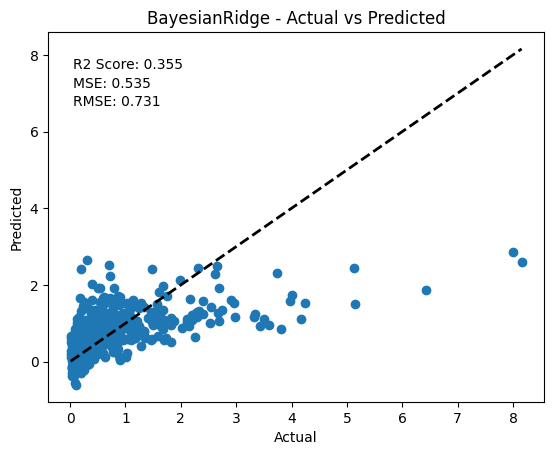

Fitting 5 folds for each of 10 candidates, totalling 50 fits


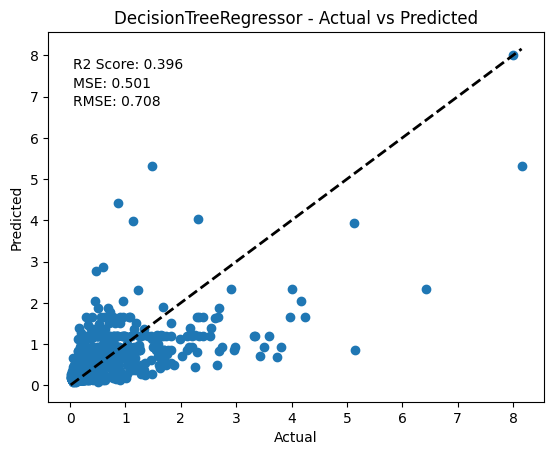

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.242e+02, tolerance: 1.429e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.578e+02, tolerance: 1.547e-01 Linear regression models with null weight for the l1 regularization term are more efficiently

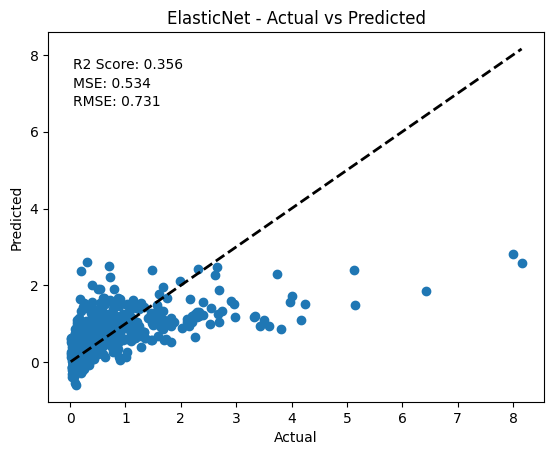

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "
c:\Users\jess_besnier\anaconda3\envs

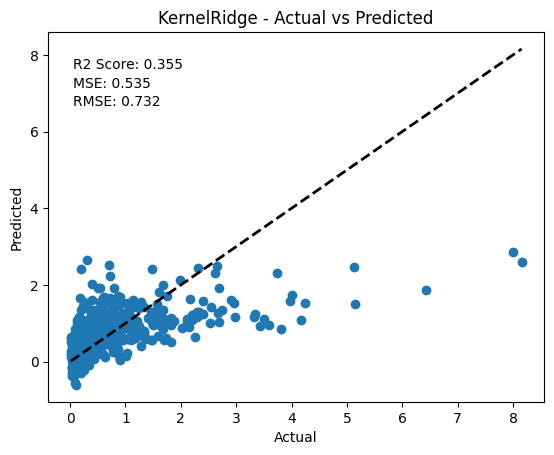

Fitting 5 folds for each of 10 candidates, totalling 50 fits


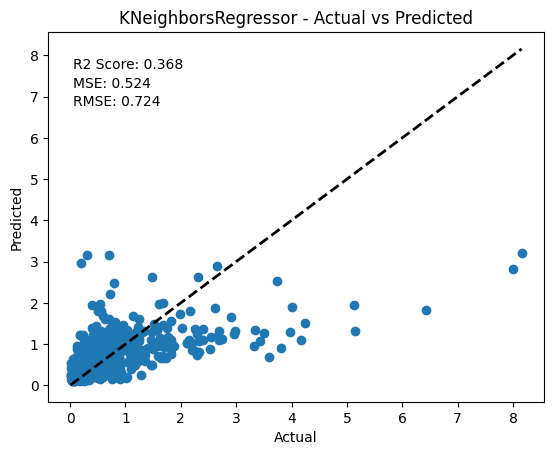

Fitting 5 folds for each of 10 candidates, totalling 50 fits


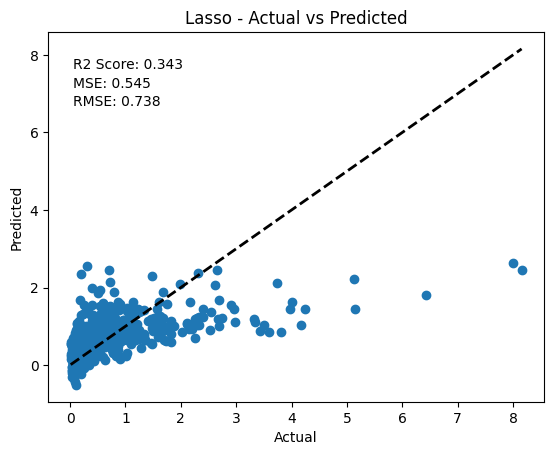

Fitting 5 folds for each of 1 candidates, totalling 5 fits


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\model_selection\_search.py:296: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


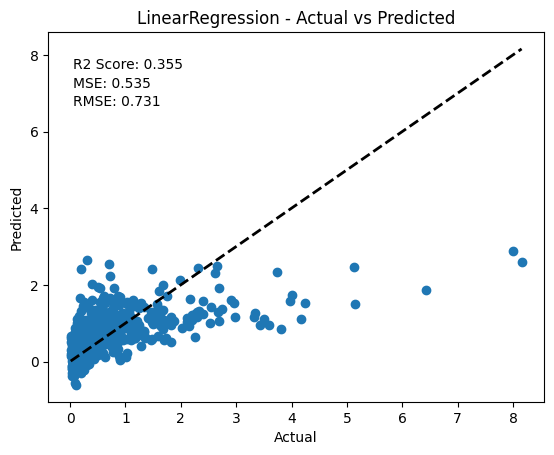

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
c:\Users\jess_besnier\ana

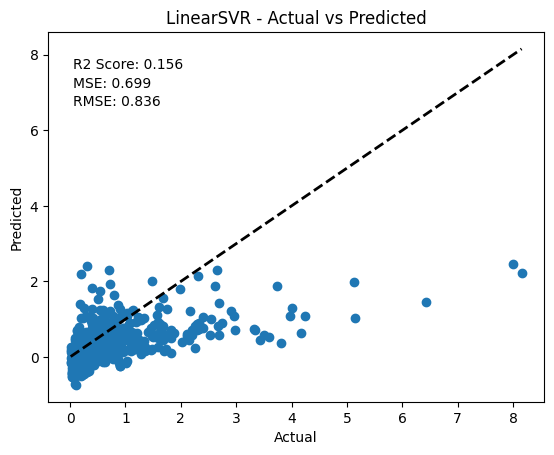

Fitting 5 folds for each of 10 candidates, totalling 50 fits


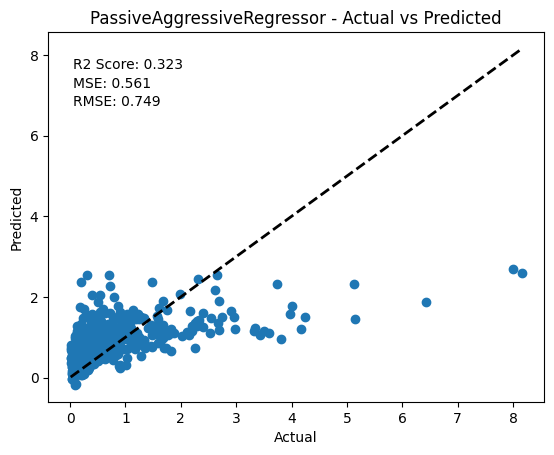

Fitting 5 folds for each of 10 candidates, totalling 50 fits


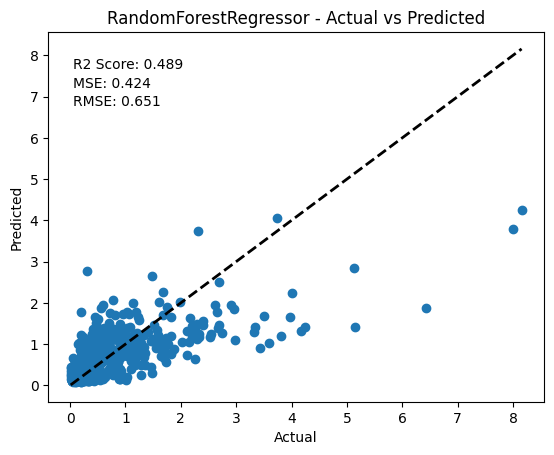

Fitting 5 folds for each of 10 candidates, totalling 50 fits


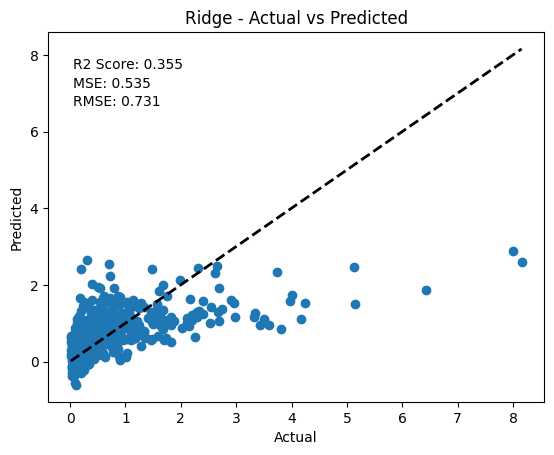

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:169: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  FutureWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:169: FutureWarning: The loss 'squared_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='squared_error'` which is equivalent.
  FutureWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consi

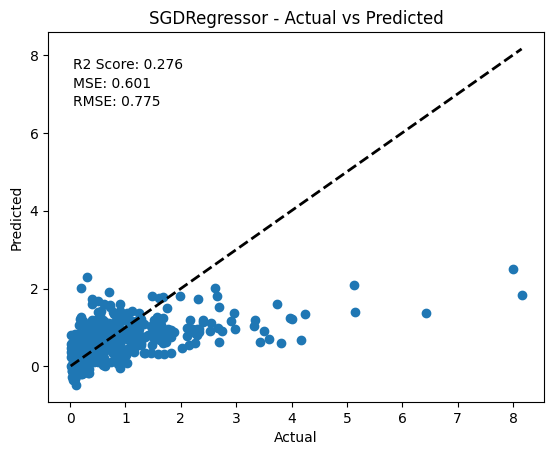

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs\mlenv\lib\site-packages\sklearn\svm\_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=150).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,
c:\Users\jess_besnier\anaconda3\envs

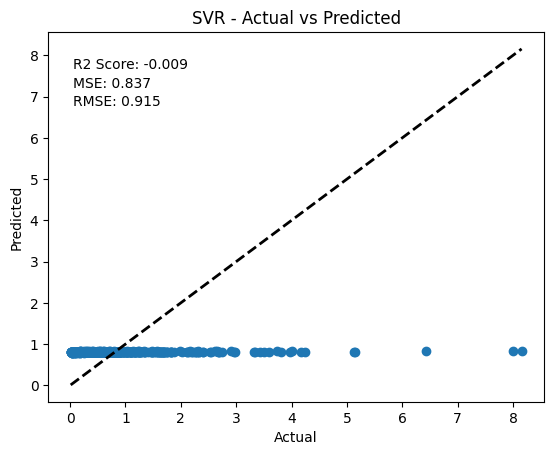

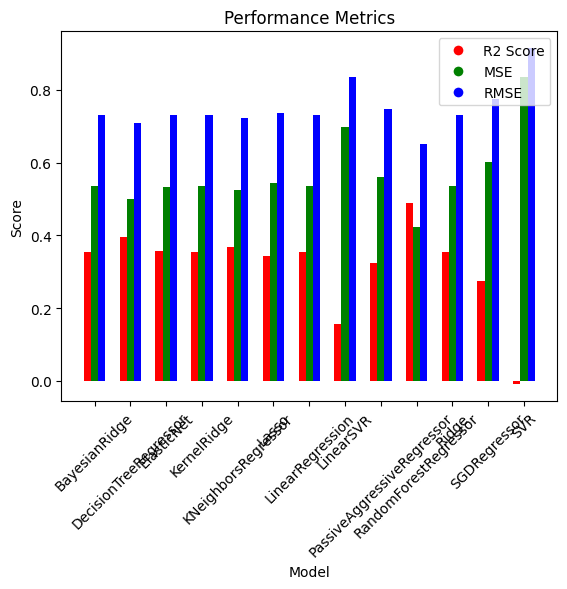

In [ ]:
#extra plots? dont need maybe
if __name__ == '__main__':

    _, X, y = create_regression_dataset()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    model_names = list(regression_models.keys())
    y_predicted = []
    r2_scores = []
    mse_values = []
    rmse_values = []

    for model_name, elements in regression_models.items():
        model = elements[0]() # Constructor
        distributions = elements[1] # hyperparameter search space

        # Train the model
        search = RandomizedSearchCV(model, param_distributions=distributions, n_iter=10, verbose=1)
        search.fit(X_train, y_train)
        y_pred = search.predict(X_test)

    # Calculate performance metrics
        r2_score_val = regression_scores(y_test, y_pred)['R2']
        mse = regression_scores(y_test, y_pred)['MSE']
        rmse = regression_scores(y_test, y_pred)['RMSE']

    # Append performance metrics to lists
        r2_scores.append(r2_score_val)
        mse_values.append(mse)
        rmse_values.append(rmse)
    # Actual vs. Predicted Values Plot with metrics
        plot_actual_vs_predicted(y_test, y_pred, model_name, r2_score_val, mse, rmse)

    # R2 Scores Plot
    #plot_r2_scores(r2_scores, model_names)

plot_performance_metrics(r2_scores, mse_values, rmse_values, list(regression_models.keys()))

    # Ranges of Predicted Values Plot
    #plot_ranges(y_pred, model_names)